# **Cyclistic Case Study - Quick Economic Research.**
### This is my first public case as a junior data analyst, and I will be working for a fictitious company called Cyclistic. As I went through the cases of other analysts, I was amazed by the numerous impressive and complex analyses that took into account factors such as weather, city maps, and participant behavior based on the day of the week and hour of the day. However, I couldn't find an answer to the main question:  
## **What is the benefit to the company of having more members with an annual subscription? I will finally tackle this question for all!**
### To conduct my research, I will be utilizing real open data from the Lyft company (https://www.lyft.com/bikes), which operates in several major cities across America where their services are highly in demand. These cities include the Bay Area, CA; Chicago, IL; Columbus, OH; Denver, CO; Washington DC; New York City; and Portland, OR. To address the key business questions, I will be following the steps of the data analysis process: **Ask, Prepare, Process, Analyze, Share, and Act**.
### The fictitious company Cyclistic, based in Chicago, wants to analyze its user data to identify significant behavioral differences between two user types: "casual" users who pay per ride, and annual members who subscribe to the service on a yearly basis. The marketing director believes that the future success of the company relies on maximizing the number of annual memberships. My goal is to conduct analytical research to support this hypothesis.

# **Ask**.
### Key goals:
### 1. Define the business problem:
### The company aims to enhance its revenues by targeting "casual" users and analyzing the differences between "casual" and annual customers. This analysis will enable the company to create a targeted and effective marketing message to encourage "casual" customers to subscribe annually.
### 2. Consider key stakeholders:
### The primary stakeholders in this project are the Chief Marketing Officer (CMO), my manager Lily Moreno, the rest of the Marketing Analyst team, and the Cyclistic executive team.
### 3. Business challenge:
### Evaluate the financial viability of this idea and calculate the financial justification for its implementation.

# **Prepare.**
### Key goals:
### 1. Examine the data:
### The data used for this research project is publicly available data from a bike rental company. It is first-hand data collected directly by the company, and its reliability can be assured. To protect privacy, no personal information of riders will be utilized. Bias is not a concern because:
## - The data is up-to-date, representing the last 12 months of information.
## - The dataset contains a large sample size, providing substantial rider information.
### 2. Sort and filter the data:
### For this analysis, I will be working with trip data from the past 12 months (June 2022 to May 2023). The data is available in CSV format and can be accessed from two sources:
### - The dataset can be obtained from https://www.kaggle.com/datasets/jboscocheung/divvy-tripdata-202206-to-202305.
### - Additional fresh data can be added from https://divvy-tripdata.s3.amazonaws.com/index.html.

In [ ]:
# Add all the necessary libraries for my analysis.
# The tidyverse packages, including dplyr and ggplot2, are specifically designed to work together in a seamless manner.
# However, there may be instances where functions with the same name exist in different packages.
# This can result in conflicts, as the R interpreter may not be able to determine which function to use.
# I will resolve these conflicts below.

library(tidyverse)
library(ggplot2)
library(lubridate)
library(geosphere)
library(gridExtra) 
library(ggmap) 
library(dplyr)
library(tidyr)
library(here)
library(skimr)
library(janitor)
library(readr)


In [ ]:
# The solution to these conflicts is to use the conflicted package. This package will force all conflicts to become errors:
install.packages("conflicted")

In [ ]:
# Once you have installed the conflicted package, you can run the following code to fix the conflicts:
library(conflicted)
conflicted::conflict_prefer("filter", "dplyr")
conflicted::conflict_prefer("lag", "dplyr")

# **Process.**
### Investigate the data source and become acquainted with the data organization.

In [ ]:
# Load the dataset 202206_to_202305.csv from "Kaggle" with show_col_types = FALSE
data_year <- read_csv("/kaggle/input/divvy-tripdata-202206-to-202305/202206_to_202305.csv", show_col_types = FALSE)
glimpse(data_year)

### Remove the specified columns from the dataset as they are not required for the quick analysis.

In [ ]:
# Delete the specified columns from the dataset
data_year <- data_year %>%
  select(-ride_id, -start_station_name, -start_station_id, -end_station_name, 
         -end_station_id, -start_lat, -start_lng, -end_lat, -end_lng)
glimpse(data_year)

### Add last dataset June-2023 from; urls <- "https://divvy-tripdata.s3.amazonaws.com/202306-divvy-tripdata.zip" 

In [ ]:
# Download, unzip and merge the June-2023.csv dataset with data_year:
urls <- "https://divvy-tripdata.s3.amazonaws.com/202306-divvy-tripdata.zip"
download.file(urls, destfile = "data_06_2023.zip")
unzip("data_06_2023.zip")
data_06_2023 <- read.csv("202306-divvy-tripdata.csv")
# Delete the specified columns from the dataset
data_06_2023 <- data_06_2023 %>%
  select(-ride_id, -start_station_name, -start_station_id, -end_station_name, 
         -end_station_id, -start_lat, -start_lng, -end_lat, -end_lng)
# Add the dataset “data_06_2023” to “data_year”
data_year <- rbind(data_year, data_06_2023)
glimpse(data_year)

### Check the dataset for errors. The first data frame will include all rows that are empty or solely consist of missing values. The second data frame will consist of all rows that contain at least one 0 value.

In [ ]:
# Check for empty rows
empty_rows <- data_year[rowSums(is.na(data_year) | data_year == "") == ncol(data_year),]
# Check for 0 values
zero_rows <- data_year[rowSums(data_year == 0) > 0,]
print(empty_rows)
print(zero_rows)

### There are no errors in my dataset. Calculate the duration of each trip in seconds.

In [ ]:
# Make a new column "ride" the difference between "start_date " and "end_date" in seconds.
data_year <- data_year %>%
  mutate(started_at = ymd_hms(started_at),
         ended_at = ymd_hms(ended_at),
         ride = as.numeric(difftime(ended_at, started_at, units = "secs")))
# Delete the specified columns from the dataset
data_year <- data_year %>% select(-ended_at)
glimpse(data_year)

# **Analysis.**
### I have obtained a comprehensive dataset containing all the necessary information for analysis.

In [ ]:
#  Create a pie chart for the "Percentage the type of riders" from column "member_casual” from dataset “data_year”:
options(repr.plot.width = 16, repr.plot.height = 6)
riders <- data_year %>%
  group_by(member_casual) %>%
  summarize(count = n())

# Group the data by "member_casual" and calculate the sum of the "ride" column for each group
ride_sums <- data_year %>%
  group_by(member_casual) %>%
  summarise(Summ = sum(ride))

plot1 <-  ggplot(riders, aes(x = "", y = count, fill = member_casual)) +
          geom_bar(stat = "identity", width = 1) +
          coord_polar("y", start=0) +
          theme_void() +
          labs(fill = "Type of Riders", title = "Percentage numbers of rides.") +
          geom_text(aes(label = paste0(round(count/sum(count)*100, 2), "%")), 
                    position = position_stack(vjust = 0.5), size = 10, color = "white") +
          scale_fill_manual(values=c("#F8766D", "#00BFC4")) +
          theme(plot.title = element_text(hjust = 0.5, size = 22, face = "bold"))
plot2 <-  ggplot(ride_sums, aes(x = "", y = Summ, fill = member_casual)) +
          geom_bar(stat = "identity", width = 1) +
          coord_polar("y", start = 0) +
          theme_void() +
          labs(fill = "Type of Riders", title = "Percentage of time bikes are used.") +
          geom_text(aes(label = paste0(round(Summ / sum(Summ) * 100, 2), "%")), 
                    position = position_stack(vjust = 0.5), size = 10, color = "white") +
          scale_fill_manual(values = c("#F8766D", "#00BFC4")) +
          theme(plot.title = element_text(hjust = 0.5, size = 22, face = "bold"))


# Combine the plots side by side
plots <- grid.arrange(plot1, plot2, ncol = 2)

# Display the plot
print(plots)

###  I have observed the data and analyzed the charts. It appears that **40%** of the riders classified as "casual" account for **60%** of the total trip duration. Additionally, I believe that the "casual" riders contribute more financially towards bike rentals.

### On this one, one could stop and argue that "casual" riders are more profitable for the company. However, we can continue and try to extract more interesting insights from this data. 
## Let's dive into my analysis! 
# **IMPORTANT!** 
### The data is incomplete. Unfortunately, I do not have access to the personal information (ID) of the riders and the statistics of breakdowns and bike returns. This limits the accuracy of our financial analysis. Nonetheless, I can utilize public information from Lyft, a similar company in New York, as well as a financial statement (https://mot-marketing-whitelabel-prod.s3.amazonaws.com/nyc/June-2023-Citi-Bike-Monthly-Report.pdf) and apply elementary logic
## **Now, it's important to note that my analysis will become biased.**
### **1**. First, I will make an assumption and exclude riders who ride less than 3 minutes, as this time is usually spent on testing and replacing a broken bike. I will also exclude riders who ride for more than 6 hours, as this could be indicative of issues with parking or a broken bicycle.
### **2**. I will assume that Regular Members take 2 trips per day, commuting to and from work. They are likely utilizing the 45-minute window to avoid incurring additional charges.
### **3**. I will assume that 80% of all riders will exhibit typical rental behavior, and I will not consider rare exceptions in rider behavior.
### **Please note** that these assumptions may introduce some bias into the analysis.

In [ ]:
# Create a copy of the data_year dataset
data_ride <- data_year

# Importante! I'll remove the noise (bad) rows from the dataset.
# Filter the rows in data_ride based on the "ride" column condition 180 sec < ride < 21600 sec
data_ride <- data_ride %>%
  filter(ride > 180 & ride < 21600)
# glimpse(data_ride)

In [ ]:
# Check for lost rows in dataset
cat(paste0("I've lost bad rows in the dataset: ", round((nrow(data_year) - nrow(data_ride)) / nrow(data_year) * 100, 2), "%\n"))
# Check for lost ride time in dataset for "casual" and "member"
cas_time <- sum(data_year$ride[data_year$member_casual == "casual"])
mem_time <- sum(data_year$ride[data_year$member_casual == "member"])
cas_time1 <- sum(data_ride$ride[data_ride$member_casual == "casual"])
mem_time1 <- sum(data_ride$ride[data_ride$member_casual == "member"])
cat(paste0("I've lost bad time for Casual: ", round((cas_time - cas_time1) / cas_time * 100, 2), "%\n"))
cat(paste0("I've lost bad time for Member: ", round((mem_time - mem_time1) / mem_time * 100, 2), "%\n"))

## Important! 
### Approximately **9%** of bad rows have been removed from the dataset, leaving us with **91%** of good data. This is even better than the planned **80%**. Additionally, **31%** of travel time was lost for "casual" riders. This suggests that these riders may be new to using a bike rental service or use it infrequently. They tend to experience more difficulties with starting and parking compared to "members" (**6%**).
### I have obtained a new dataset after removing the noisy (bad) rows. Let's examine the differences.

In [ ]:
#  Create a pie chart for the "Percentage the type of riders" from column "member_casual” from dataset “data_year”:
options(repr.plot.width = 16, repr.plot.height = 6)
riders1 <- data_ride %>%
  group_by(member_casual) %>%
  summarize(count = n())

# Group the data by "member_casual" and calculate the sum of the "ride" column for each group
ride_sums1 <- data_ride %>%
  group_by(member_casual) %>%
  summarise(Summ = sum(ride))

plot1 <-  ggplot(riders1, aes(x = "", y = count, fill = member_casual)) +
          geom_bar(stat = "identity", width = 1) +
          coord_polar("y", start=0) +
          theme_void() +
          labs(fill = "Type of Riders", title = "Percentage numbers of rides.") +
          geom_text(aes(label = paste0(round(count/sum(count)*100, 2), "%")), 
                    position = position_stack(vjust = 0.5), size = 10, color = "white") +
          scale_fill_manual(values=c("#F8766D", "#00BFC4")) +
          theme(plot.title = element_text(hjust = 0.5, size = 22, face = "bold"))
plot2 <-  ggplot(ride_sums1, aes(x = "", y = Summ, fill = member_casual)) +
          geom_bar(stat = "identity", width = 1) +
          coord_polar("y", start = 0) +
          theme_void() +
          labs(fill = "Type of Riders", title = "Percentage of time bikes are used.") +
          geom_text(aes(label = paste0(round(Summ / sum(Summ) * 100, 2), "%")), 
                    position = position_stack(vjust = 0.5), size = 10, color = "white") +
          scale_fill_manual(values = c("#F8766D", "#00BFC4")) +
          theme(plot.title = element_text(hjust = 0.5, size = 22, face = "bold"))


# Combine the plots side by side
plots <- grid.arrange(plot1, plot2, ncol = 2)

# Display the plot
print(plots)

### I observe that **41%** of "casual" riders account for **52.5%** of their total ride time. This is because I have excluded **31%** of erroneous travel time for "casual" riders and **6%** for "members" by removing those rides.
### To conduct a more detailed analysis, I will divide my dataset "data_ride" into "data_casual" and "data_member.":

In [ ]:
# Divide the “data_ride” into “data_casual” and “data_member” for the column “member_casual”
data_casual <- data_ride %>% filter(member_casual == "casual")
data_member <- data_ride %>% filter(member_casual == "member")
# Sort the data frame "data_member" by the "ride" column in ascending order
data_member <- data_member[order(data_member$ride), ]
glimpse(data_casual)
glimpse(data_member)

### I will calculate the cost for each trip made by "casual" and "member" riders based on the pricing rules provided in the image below or from the website: https://divvybikes.com/pricing.

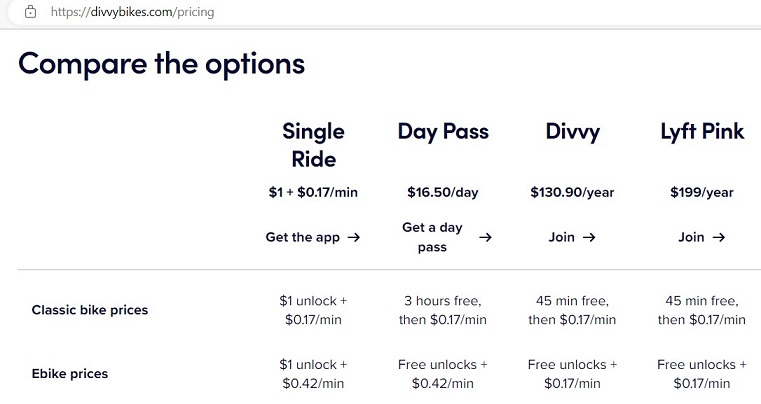

### Now, I will calculate the total sum of money for each trip made by casual riders: 

In [ ]:
# Make a funtion for count the money for the each trip of "casual"; where 3 hours = 10,800 sec: 
casual <- function(data_casual) {
  data_casual$money <- ifelse(data_casual$rideable_type != "electric_bike" & data_casual$ride > 10800,
                              16.5 + (data_casual$ride - 10800) / 60 * 0.17,
                              ifelse(data_casual$rideable_type != "electric_bike",
                                     1 + data_casual$ride / 60 * 0.17,
                                     ifelse(data_casual$rideable_type == "electric_bike",
                                            1 + data_casual$ride / 60 * 0.42,
                                            0)))
  return(data_casual)
}

# Call the casual function to add the "money" column to data_casual
data_casual <- casual(data_casual)

# Check the result using glimpse()
# glimpse(data_casual)
# Count Total Money from "casual" in period of 13 months
casual_total <- round(sum(data_casual$money), 2)
cat(paste0("Total money from Casual in period of 13 months: ", casual_total, " USD\n"))

### I will evaluate the data for members. In the calculation, I will take into account a 45-minute free window to determine any additional charges for "Members".

In [ ]:
# Make a funtion for count the extra money for the each trip of "member"; where 45 minutes = 2700 sec: 
member <- function(data_member) {
  data_member$money <- ifelse(data_member$ride > 2700, (data_member$ride - 2700) / 60 * 0.17,
                                0)
  return(data_member)
}
# Call the casual function to add the "money" column to data_casual
data_member <- member(data_member)
# Check the result using glimpse()
# glimpse(data_member)
cat(paste0("Total EXTRA money from Member in period of 13 months: ", round(sum(data_member$money), 2), " USD\n"))

## The sum (291,558 USD) does not seem serious! **Remember**, I am conducting a biased analysis.
### I will assume that regular members make 2 trips a day, one to work and one back. They will try to utilize the 45-minute window to avoid paying extra money.
### Find the pair of member trips with the maximum count in a single day:

In [ ]:
# Delete all even rows in my dataset “data_member” because it's a round trip
data_member <- data_member[-seq(2, nrow(data_member), 2), ]
# glimpse(data_member)

In [ ]:
# Increase all values in the “ride” column by 2 times because it's a round trip
data_member$ride <- data_member$ride * 2
# glimpse(data_member)

In [ ]:
# Make a funtion for count the extra money for the each trip of "member"; where 45 minutes = 2700 sec: 
member <- function(data_member) {
  data_member$money <- ifelse(data_member$ride > 2700, (data_member$ride - 2700) / 60 * 0.17,
                                0)
  return(data_member)
}

# Call the casual function to add the "money" column to data_casual
data_member <- member(data_member)
cat(paste0("Total EXTRA money from Member in period of 13 months: ", round(sum(data_member$money), 2), " USD\n"))

## I need to determine the number of members for my analysis. I will find the maximum number of trips per day made by members. Perhaps it constitutes 30% of all members?

In [ ]:
# Find a Maximum pair raids of Member in a day:
# Sort the dataset by "started_at" column
data_member_sorted <- data_member %>%
  arrange(started_at)

# Group the data by date and calculate the sum of rows in each group
data_member_sum_per_day <- data_member_sorted %>%
  group_by(date = as.Date(started_at)) %>%
  summarise(max_sum_per_day = n())

# Find the maximum sum of rows in a day
max_sum <- max(data_member_sum_per_day$max_sum_per_day)

# Filter the rows with the maximum sum of rows in a day
max_sum_rows <- data_member_sum_per_day %>%
  filter(max_sum_per_day == max_sum)

# Extract the date with the maximum sum of rows
date_with_max_sum <- max_sum_rows$date

# Display the result
cat(paste0("Maximum pair raids of Member : ", round(max_sum, 0), "   in a date : ", date_with_max_sum, ", Wednesday \n"))

In [ ]:
# Total number of Members in Chicago: 
num_members <- max_sum/0.30
cat(paste0("The total number of Members in 2023 in Chicago is approximately : ", round(num_members, 0), ", Wednesday\n"))

### To support my research, I'm using the blue line at the picture **"Cycling in the city"** below : https://www.nyc.gov/html/dot/downloads/pdf/cycling-in-the-city-2021.pdf

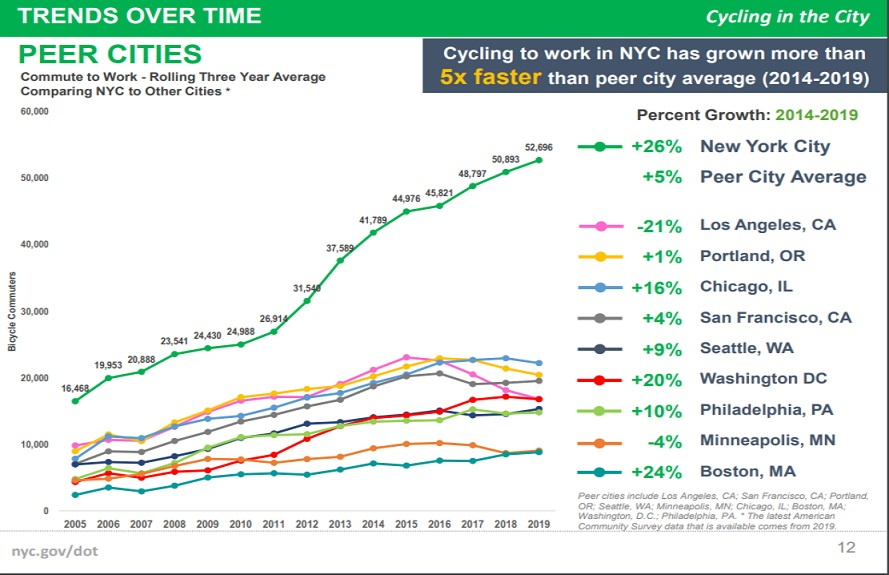

### I will calculate how much money membership fees could bring for the **LIFT** company for 13 months. Again, suppose **90% Members** paid an annual subscription 130.9 USD and **10% Members** paid 199 USD.

In [ ]:
# Calculate money membership fees and Total:
mem_money <- (num_members*0.9*130.9+num_members*0.1*199)/12*13
cat(paste0("The membership fees : ", round(mem_money, 0), " USD\n"))
mem_total <- round(sum(data_member$money)+ mem_money, 0)  
cat(paste0("The total Money of Members is approximately : ", round(mem_total, 0), " USD\n"))

In [ ]:
# Persentage of money for Members in Chicago:
Mem_money_pers <- round((mem_total) / (mem_total+casual_total) * 100, 2)
Casual_money_pers <- 100-Mem_money_pers
cat(paste0("Persentage of money for Members in Chicago: ", Mem_money_pers, "%\n"))
cat(paste0("Persentage of money for Casual in Chicago: ", Casual_money_pers, "%\n"))

### To support my research, I'm using the picture for NYC " Financial Summary - December YTD" below : https://mot-marketing-whitelabel-prod.s3.amazonaws.com/nyc/December-2022-Citi-Bike-Monthly-Report.pdf

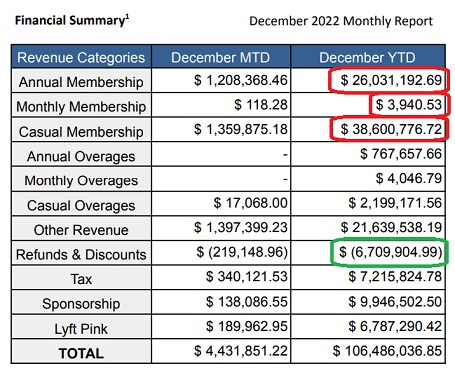

# Persentage of money for Members in NYC:
NYC_member <- 26031193+3941
NYC_casual <- 38600777
NYC_refunds <- 6709905
NYC_mem_pers <- round((NYC_member) / (NYC_member+NYC_casual) * 100, 2)
NYC_casual_pers <- 100-NYC_mem_pers
cat(paste0("Persentage of money for Members in NYC: ", NYC_mem_pers, "%\n"))
cat(paste0("Persentage of money for Casuals in NYC: ", NYC_casual_pers, "%\n"))
cat(paste0("Persentage of Refunds for Riders in NYC: ", round(NYC_refunds/(NYC_member+NYC_casual)*100, 2), "%\n"))

### WOW! The return rate for riders in New York is 10.38%. Looks like 9% of bad data has been removed from my dataset!

In [ ]:
# Pie chars for Chicago and NYC:

options(repr.plot.width = 16, repr.plot.height = 6)
df_chicago <- data.frame(
  category = c("Members", "Casuals"),
  percentage = c(Mem_money_pers, Casual_money_pers)
)

df_nyc <- data.frame(
  category = c("Members", "Casuals"),
  percentage = c(NYC_mem_pers, NYC_casual_pers)
)
plot1 <-  ggplot(df_chicago, aes(x="", y=percentage, fill=category)) +
          geom_bar(width = 1, stat = "identity") +
          coord_polar("y", start=0) +
          theme_void() +
          labs(fill = "Type of Riders", title = "Percentage of Money in Chicago") +
          geom_text(aes(label = paste0(round(percentage, 2), "%")), 
                   position = position_stack(vjust = 0.5), size = 10, color = "white") +
          scale_fill_manual(values = c("#F8766D", "#00BFC4")) +
          theme(plot.title = element_text(hjust = 0.5, size = 22, face = "bold"))

plot2 <-  ggplot(df_nyc, aes(x="", y=percentage, fill=category)) +
          geom_bar(width = 1, stat = "identity") +
          coord_polar("y", start=0) +
          theme_void() +
          labs(fill = "Type of Riders", title = "Percentage of Money in NYC") +
          geom_text(aes(label = paste0(round(percentage, 2), "%")), 
                   position = position_stack(vjust = 0.5), size = 10, color = "white") +
          scale_fill_manual(values = c("#F8766D", "#00BFC4")) +
          theme(plot.title = element_text(hjust = 0.5, size = 22, face = "bold"))

# Combine the plots side by side
plots <- grid.arrange(plot1, plot2, ncol = 2)

# Display the plot
print(plots)

### 

### I can see that the pictures show **similar trends** for 'Casual' and 'Member' riders in terms of the total amount of money spent in **Chicago** and **NYC**.

# CONCLUSIONS:
### **1.** We can't use incomplete data and get a good analysis.
### **2.** I was not able to obtain the data I needed for analysis from the supplier (**Cyclistic company**) and therefore tried to incorporate open data from other sources into my analysis.
### **3.** My biased analysis conclusively showed that **Cyclistic company** would not be able to increase its revenues by attracting **Casual** riders to purchase an annual membership. The hypothesis put forward by the CMO and my manager Lily Moreno was not confirmed.
### **4.** My **simple logic** at the very beginning told me that most of the **Casual** riders are tourists who do not live in Chicago. If a **Casual** rider decides to become a **Member**, they will end up paying less money to the company. Therefore, the company's income will be **reduced** if it follows this strategy.
### **5.** Pie charts were the most suitable type of chart for this type of analysis.
### **6.** Let's add a couple more interesting data analyzes, which, however, will not change the main conclusion of the study.

### I will make a combo chart for the first 60 minutes to see the bike usage preferences of the different groups of riders - Casual and Member with round rides.

In [ ]:
# Add a new column to each data frame to differentiate the two categories
data_member$Category <- "Member"
data_casual$Category <- "Casual"

# Combine the two data frames into a single data frame
combo_data <- rbind(data_member, data_casual)

# Convert ride_length to minutes
combo_data$ride_length_minutes <- combo_data$ride / 60

# Load the required library
library(ggplot2)

# Create the 2-color linear graphic with bigger title size and horizontal lines
plot1 <- ggplot(combo_data, aes(x = ride_length_minutes, fill = Category)) +
  geom_density(alpha = 0.7) +
  labs(title = "The preferred time of using bicycles - Casual and Member round rides.",
       x = "Ride Length (minutes)",
       y = "Number of Riders, million") +
  scale_x_continuous(limits = c(2, 60), breaks = seq(0, 60, by = 2)) +
  scale_fill_manual(values = c("orange", "skyblue"), labels = c("Casual", "Member")) +
  theme(plot.title = element_text(hjust = 0.5, size = 22, face = "bold"),
        axis.title = element_text(size = 22, face = "bold"))

# Add horizontal lines
plot1 <- plot1 +
  geom_hline(yintercept = c(0.0092, 0.012, 0.024, 0.031), linetype = 'dashed', color = 'red')

# Add labels to horizontal lines
plot1 <- plot1 +
  annotate("text", x = 20, y = 0.0092, label = "80%", size = 5, color = "blue") +
  annotate("text", x = 20, y = 0.012, label = "80%", size = 5, color = "orange") +
  annotate("text", x = 20, y = 0.024, label = "50%", size = 5, color = "blue") +
  annotate("text", x = 20, y = 0.031, label = "50%", size = 5, color = "orange")

# Print the updated plot
print(plot1)


### I see 50% of Casuals ride less than 19 minutes and 50% of Members ride less than 23 minutes for round trip. And I see 80% of Casuals ride less than 34 minutes for singl trip and 80% of Members ride less than **39 minutes** for round trip. Member's behavior is caused by a **45 minute limit**, after which they are forced to pay extra money. Casuals ones have no such restrictions.

In [ ]:
# Sort the columns "started_at" for both datasets by day:
data_casual <- data_casual %>% 
  arrange(as.Date(started_at))

data_member <- data_member %>% 
  arrange(as.Date(started_at))

# Count the rows for each day in both datasets
casual_counts <- data_casual %>% 
  group_by(date = as.Date(started_at)) %>% 
  summarize(count = n())

member_counts <- data_member %>% 
  group_by(date = as.Date(started_at)) %>% 
  summarize(count = n())

# Create the lines graph for Casual and Member for all days
ggplot() +
  geom_line(data = casual_counts, aes(x = date, y = count, color = "Casual"), size = 1.5) +
  geom_line(data = member_counts, aes(x = date, y = count, color = "Member"), size = 1.5) +
  labs(title = "Bike Ride Counts by Day - Casual and Member by round trip.",
       x = "Date",
       y = "Count",
       color = "Category") +
  scale_color_manual(values = c("Casual" = "orange", "Member" = "blue")) +
  theme(plot.title = element_text(hjust = 0.5, size = 22, face = "bold"),
        axis.title = element_text(size = 22, face = "bold"))


### I see the numbers of Casual riders less than Member by round trip in a cold season.
### What type of bike do riders prefer?

In [ ]:
# What type of bike do riders prefer?
# Sort the columns "rideable_type" for data_casual and data_member by bike type
data_casual <- data_casual[order(data_casual$rideable_type), ]
data_member <- data_member[order(data_member$rideable_type), ]

# Count the sum in column "ride" for each type of bike and convert values from seconds to minutes
casual_count <- aggregate(ride ~ rideable_type, data = data_casual, FUN = sum)
casual_count$ride <- casual_count$ride / 60

member_count <- aggregate(ride ~ rideable_type, data = data_member, FUN = sum)
member_count$ride <- member_count$ride / 60

# Make the separate bar plots for Casual and Member
library(ggplot2)

# Bar plot for Casual
casual_plot <- ggplot(casual_count, aes(x = rideable_type, y = ride, fill = "Casual")) +
  geom_bar(stat = "identity", width = 0.5) +
  scale_fill_manual(values = "orange", labels = "Casual") +
  labs(title = "Total ride time per bike type - Casual",
       x = "Bike Type",
       y = "Total Ride Time (minutes)") +
  theme(plot.title = element_text(hjust = 0.5, size = 22, face = "bold"),
        axis.title = element_text(size = 22, face = "bold"))

# Bar plot for Member
member_plot <- ggplot(member_count, aes(x = rideable_type, y = ride, fill = "Member")) +
  geom_bar(stat = "identity", width = 0.5) +
  scale_fill_manual(values = "skyblue", labels = "Member") +
  labs(title = "Total ride time per bike type - Member",
       x = "Bike Type",
       y = "Total Ride Time (minutes)") +
  theme(plot.title = element_text(hjust = 0.5, size = 22, face = "bold"),
        axis.title = element_text(size = 22, face = "bold"))

# Combine both plots side by side
library(gridExtra)
grid.arrange(casual_plot, member_plot, ncol = 2)


### I observed that both **Casual** and **Member** riders tend to choose **classic** and **electric** bike types in a similar proportion. However, the **docked** type of bike was chosen exclusively by **Casual** riders..
### What is Total revenue per bike type for Casual?

In [ ]:
# What is Total revenue per bike type for Casual?
# Sort the columns "rideable_type" for 3 type of bike
data_casual <- data_casual[order(data_casual$rideable_type),]

# Count the sum in column "ride" for each type of bike, convert values from seconds to minutes
casual_count <- aggregate(ride ~ rideable_type, data = data_casual, FUN = sum)
casual_count$ride <- casual_count$ride / 60

# Count the sum in column "money" for each type of bike
casual_money <- aggregate(money ~ rideable_type, data = data_casual, FUN = sum)

# Make the a pie char for the sum in column "money" for each type of bike
library(ggplot2)
ggplot(casual_money, aes(x="", y=money, fill=rideable_type)) +
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0) +
  theme_void() +
  labs(title = "Total revenue per bike type - Casual",
       x = "",
       y = "") +
  theme(plot.title = element_text(hjust = 0.5, size = 22, face = "bold")) +
  geom_text(aes(label=paste0(rideable_type,"\n","$ ",round(money/1000000,2),"M")), position=position_stack(vjust=0.5), size=8) +
  scale_fill_manual(values=c("orange", "skyblue", "green"))


### The income from the electric bike is more than other types of bikes from Casual's riders.
### How much does it cost on average to rent a bike per minute for different types of riders, including payment 1 USD for unlocking?

In [ ]:
# Count the sum in column "ride" for each type of bike and Devide the each sum for 60 (it need for the minutes)
Time_sum <- aggregate(ride ~ rideable_type, data = data_casual, FUN = sum)
Time_sum$ride <- Time_sum$ride / 60

# Count the sum in column "money" for each type of bike
Time_money <- aggregate(money ~ rideable_type, data = data_casual, FUN = sum)

# Devide the each Variables Time_sum for Variables Time_money for each type of bike
Price_per_minute <- data.frame(rideable_type = Time_sum$rideable_type,
                               price_per_minute = round(Time_money$money / Time_sum$ride, 2))

# Add member rider price per minute
mem_price_min <- 0.104
Price_per_minute <- rbind(Price_per_minute, data.frame(rideable_type = "Member", price_per_minute = mem_price_min))

# Make the a bars char for the results for each type of bike and add lable "Price per minute"
library(ggplot2)
ggplot(Price_per_minute, aes(x=rideable_type, y=price_per_minute, fill=rideable_type)) +
  geom_bar(stat="identity", width=0.5) +
  geom_text(aes(label=paste0("$", price_per_minute)), vjust=1.6, color="black", size=10) +
  scale_fill_manual(values=c("orange", "skyblue", "green", "red")) +
  labs(title = "Average Price per minute for Casual / Member",
       x = "Bike Type",
       y = "Price per Minute") +
  theme(plot.title = element_text(hjust = 0.5, size = 22, face = "bold"),
        axis.title = element_text(size = 22, face = "bold"))

### Nice picture! It appears that Cyclistic company would not be able to increase its revenues by attracting Casual riders to purchase an annual membership because the price for one minute of bike rental for Members is at least **two times less** than that for Casual riders.

# **Share.**
### I attempted to conduct a quick and easy analysis of the hypothesis. While I could have spent a lot of time researching all the intricacies of rider behavior, it would have been pointless to waste time and resources on answering the main question. It was more efficient for my company to make a quick assessment and move on to other hypotheses and projects.
### Thanks to everyone who has read my biased analysis up to this point.
### I would be glad to know your opinion.